In [ ]:
# Demo Post-Processing

## Job Setup

In [41]:
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os
import ast
import glob
import codecs
import inspect
import warnings
import itertools
import datetime

import pyproj
import shapely

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from IPython.display import display

%autoreload 2
import toolbox as tb
%autoreload 2
import source_model_tools as smt
%autoreload 2
import gmpe_tools as gmt

from hmtk import sources as src
import hmtk

%autoreload 2
import oq_output.hazard_curve_converter as hcc
%autoreload 2
import oq_output.hazard_map_converter as hmc

from openquake.hazardlib import geo

## Hazard Curves

In [43]:
def get_elapsed_time_from_log_file(calc_id, root_dir='.'):
    log_file = tb.find_files('calc_%d.log' % calc_id, root_dir)[0]
    with open(log_file, 'r') as f:
        lines = f.readlines()
    times = [datetime.datetime.strptime(line[1:].split(',')[0], "%Y-%m-%d %H:%M:%S") for line in lines]
    delta = times[-1] - times[0]
    
    return str(delta)

In [79]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50.  # years
rate = -np.log(1 - poes_nom)/T_nom  # per year
T_ref = 20.  # year
poes_ref = 1 - np.exp(-rate*T_ref)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]

print('investigation_time = %s' % str(T_ref))
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_ref]))
print(poe_labels)

investigation_time = 1.0
poes = 0.002105 0.00040397
['10% in 50 years', '2% in 50 years']


In [92]:
export_path = '/tmp/openquake'
jobs = [
    '10 years',
    '20 years',
    '50 years',
    '100 years',
    '200 years',
    '500 years',
    ]
calc_ids = [217, 222, 218, 220, 221, 219]  
T_invs = [10., 20., 50., 100., 200., 500.]
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
quantile = '_b1-' # numeric for percentile, 0.5 for median, 'mean' for mean

subset_keys = ['_curve-', str(quantile)]

if quantile == 0.5:
    quantile_string = 'median'
elif tb.is_numeric(quantile):
    quantile_string = '%gth' % (100*quantile)
else:
    quantile_string = quantile

In [93]:
list_results = []

for job, calc_id, T_inv, line_style in zip(jobs, calc_ids, T_invs, line_styles):
    exported_files = [os.path.join(export_path, dir_path, f)
        for dir_path, _, files in os.walk(export_path)
        for f in files if f.endswith('.xml') and '_%d' % calc_id in f]
    output_subset = [item for item in exported_files if all(key in item for key in subset_keys)]

    if len(output_subset) == 0:
        print('No files found for %s calc ID %d' % (job, calc_id))
    for file_name in sorted(output_subset):
        hcm = hcc.read_hazard_curves(file_name)
        
        if abs(hcm['investigation_time']/T_inv - 1) > 1e-3:
            print('expected %g year investigation time but found %g' % 
                  (T_inv, hcm['investigation_time']))

        for row in hcm['curves']:
            dict_results = {
                    'job': job,
                    'file': file_name,
                    'ID': calc_id,
                    'IMT': hcm['imt'],
                    'quantile': quantile_string,
                    'investigation time': hcm['investigation_time'],
                }
            for key, value in zip(hcm['imls'], row[2:]):
                dict_results[key] = value
            list_results.append(pd.Series(dict_results))

df_results = pd.DataFrame(list_results)
df_results = gmt.df_massage(df_results)

In [94]:
imts = ['PGA', 'SA(0.2)', 'SA(1)']
df_results = pd.concat([df_results[df_results['IMT'] == imt] for imt in imts])
display(df_results)

,ID,IMT,file,investigation time,job,quantile,0.005,0.007,0.0098,0.0137,...,160.0,170.0,180.0,190.0,200.0,220.0,240.0,260.0,280.0,300.0
0,217,PGA,/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,10,10 years,_b1-,0.952702,0.949193,0.940521,0.922042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,218,PGA,/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,50,50 years,_b1-,1.000000,1.000000,0.999999,0.999997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,219,PGA,/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,500,500 years,_b1-,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,220,PGA,/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,100,100 years,_b1-,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,221,PGA,/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,200,200 years,_b1-,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,222,PGA,/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,20,20 years,_b1-,0.997763,0.997419,0.996462,0.993923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,217,SA(0.2),/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,10,10 years,_b1-,0.954161,0.954029,0.953384,0.951246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,218,SA(0.2),/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,50,50 years,_b1-,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,219,SA(0.2),/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,500,500 years,_b1-,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,220,SA(0.2),/tmp/openquake/hazard_curve-smltp_b1-gsimltp_b...,100,100 years,_b1-,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


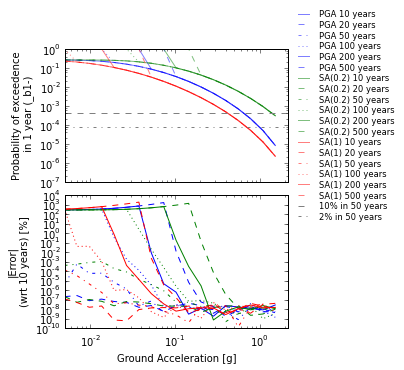

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(4,5), sharex=True)
fig.subplots_adjust(hspace=0.1)
imls = [item for item in df_results.columns if tb.is_numeric(item)]
imts = sorted(list(set(df_results['IMT'])))

for imt, color in zip(imts, axes[0]._get_lines.color_cycle):

    df_imt = df_results[df_results['IMT'] == imt]

    poes = np.array([[df_imt[df_imt['job'] == job][iml].values[0] for iml in imls] for job in jobs])
    T_invs = np.array([[df_imt[df_imt['job'] == job]['investigation time'].values[0] for iml in imls] for job in jobs])
    poes_converted = 1 - np.exp(np.log(1 - poes)*T_ref/T_invs)
    
    for result, job, linestyle in zip(poes_converted, jobs, line_styles):
        axes[0].loglog(imls, result, 
                       linestyle=linestyle, color=color, label=imt + ' ' + job, alpha=0.5)
    for result, job, linestyle in zip(poes_converted[1:,:], jobs[1:], line_styles[1:]):
        axes[1].loglog(imls, np.abs(result/poes_converted[0,:] - 1)*100, 
                         linestyle=linestyle, color=color, label=imt + ' ' + job)

for prob, label, linestyle in zip(poes_ref, poe_labels, line_styles[1:]):
    axes[0].axhline(100*(1 - np.exp(np.log(1 - prob)/T_inv)), 
                    label=label, color='0.5', linestyle=linestyle)

axes[0].set_ylabel('Probability of exceedence\n in %g year (%s)' % (T_ref, quantile_string))
axes[1].set_ylabel('|Error|\n(wrt %s) [%%]' % (jobs[0]))
axes[1].set_xlabel('Ground Acceleration [g]')
axes[1].autoscale(True, 'x', 'tight')
#axes[0].set_ylim((1e-4, 1))
#axes[1].set_ylim((-10, 10))
axes[0].legend(loc='center left', frameon=False, bbox_to_anchor=(1, 0.5), fontsize='small', labelspacing=0.2)

file_name = 'AreaSourceClassicalPSHA_%s_%gyear.pdf' % (quantile_string, T_ref)
fig.savefig(file_name, dpi=600, bbox_inches='tight', transparent=True)